# Binary Classification with a Software Defects Dataset
Playground Series - Season 3, Episode 23
https://www.kaggle.com/competitions/playground-series-s3e23/data

In [2]:
# Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:
# Read data
data = pd.read_csv("data/train.csv")

In [4]:
data.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


### Attribute Information:
1. ***loc***             : numeric % McCabe's line count of code
2. ***v(g)***            : numeric % McCabe "cyclomatic complexity"
3. ***ev(g)***           : numeric % McCabe "essential complexity"
4. ***iv(g)***           : numeric % McCabe "design complexity"
5. ***n***               : numeric % Halstead total operators + operands
6. ***v***               : numeric % Halstead "volume"
7. ***l***               : numeric % Halstead "program length"
8. ***d***               : numeric % Halstead "difficulty"
9. ***i***               : numeric % Halstead "intelligence"
10. ***e***               : numeric % Halstead "effort"
11. ***b***               : numeric % Halstead 
12. ***8***               : numeric % Halstead's time estimator
13. ***lOCode***          : numeric % Halstead's line count
14. ***lOComment***       : numeric % Halstead's count of lines of comments
15. ***lOBlank***         : numeric % Halstead's count of blank lines
16. ***lOCodeAndComment***: numeric
17. ***uniq_Op***         : numeric % unique operators
18. ***uniq_Opnd***      : numeric % unique operands
19. ***total_Op***        : numeric % total operators
20. ***total_Opnd***      : numeric % total operands
21. ***branchCount***     : numeric % of the flow graph
22. ***defects***         : {false,true} % module has/has not one or more % reported defects

In [5]:
# Drop id since id is basically row number
data.drop("id", axis=1, inplace=True)

In [6]:
data.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [7]:
# Mark target column while all other columns are continuous
TAR = ["defects"]

In [8]:
data.columns.values

array(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b',
       't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'], dtype=object)

In [9]:
# Check distributions
def plot_dist(log_scale=False):
    fig, axes = plt.subplots(5, 5, figsize=(24, 20))
    cols = data.columns
    for i in range(5):
        for j in range(5):
            idx = i*5+j
            if idx > len(cols)-1:
                return
            sns.histplot(ax=axes[i, j], data=data[cols[idx]] + 0.0001, kde=True, bins=15, log_scale=log_scale)


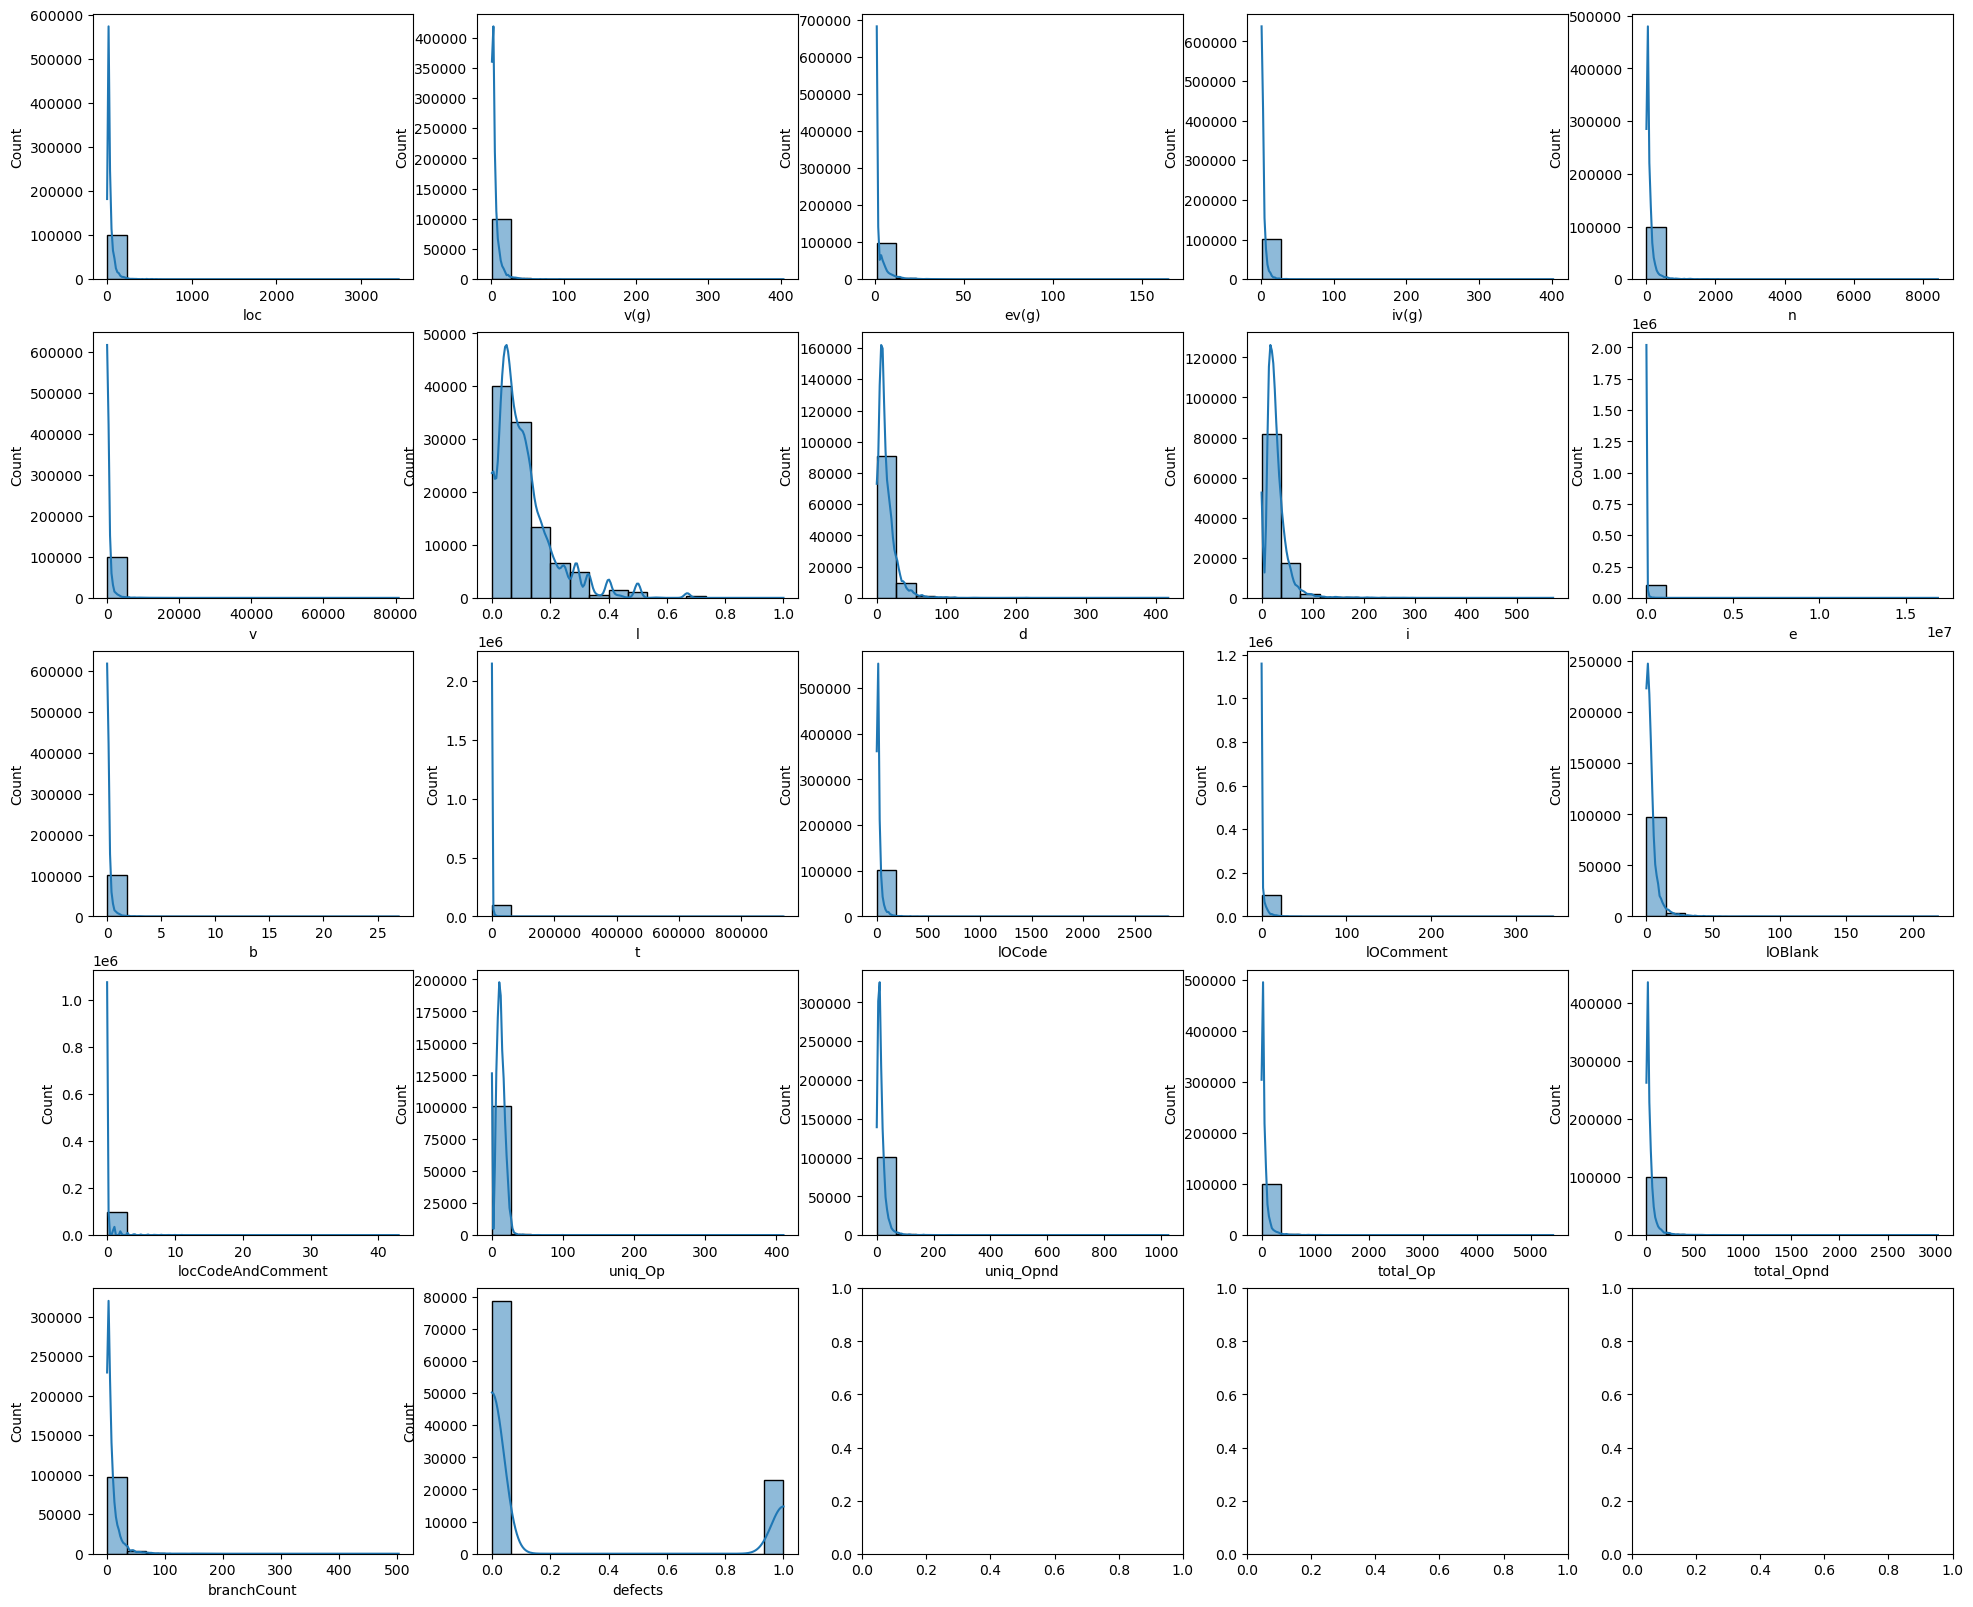

In [10]:
plot_dist()

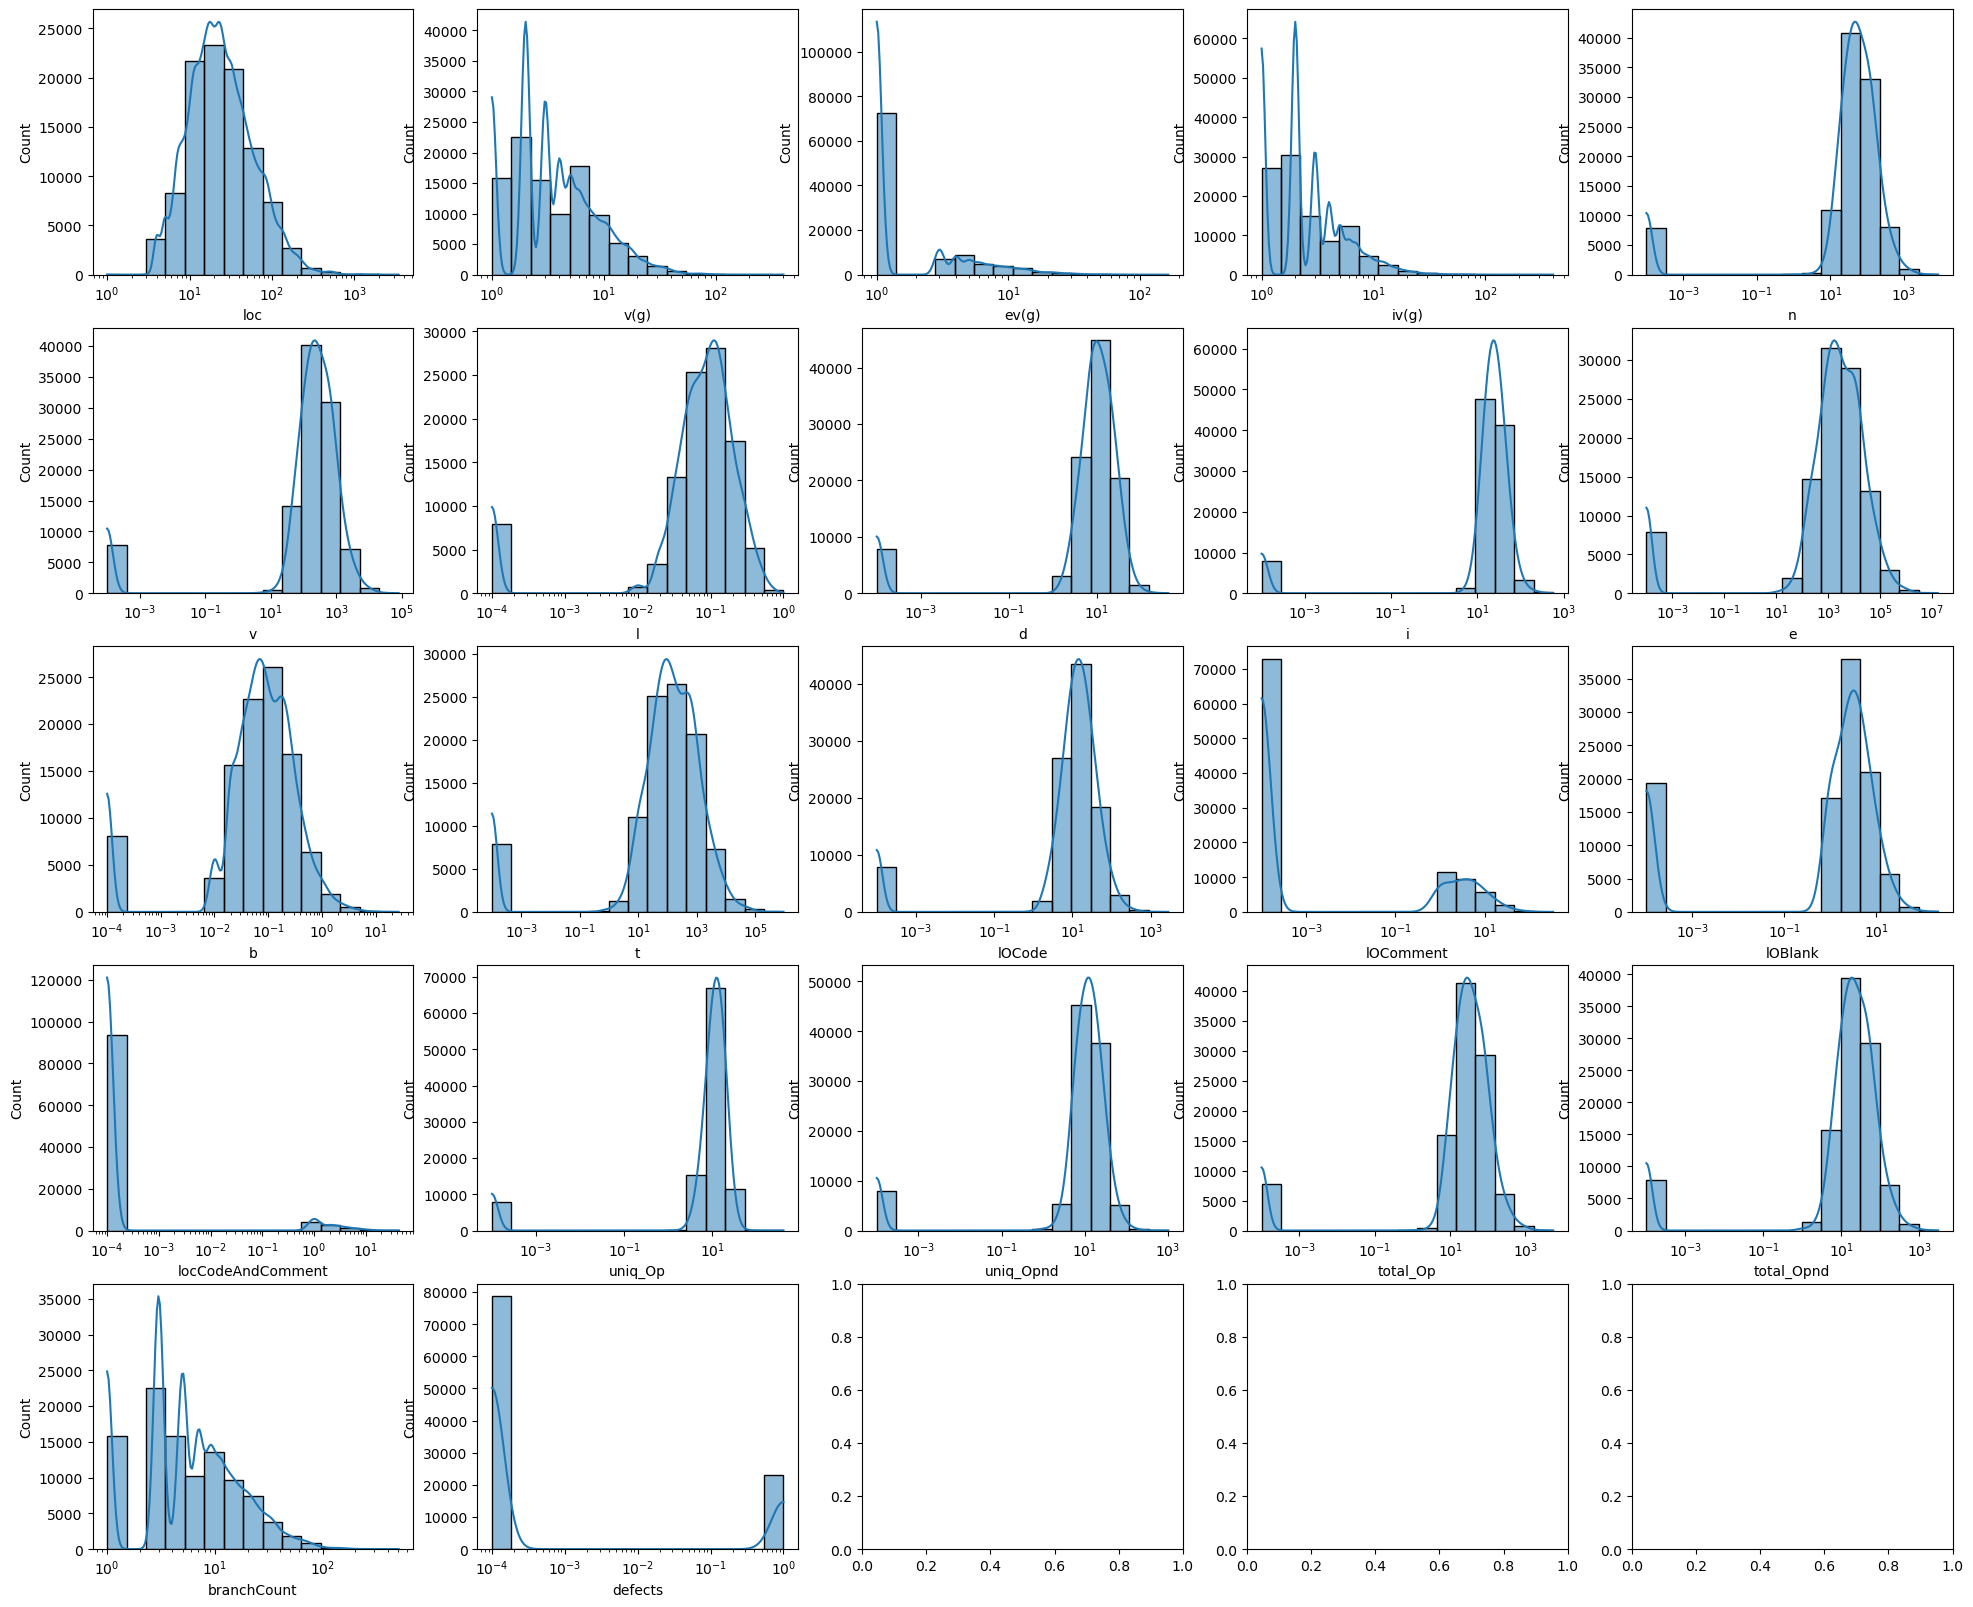

In [11]:
plot_dist(log_scale=True)

In [12]:
# Notice after log-transform some variables attain a likely Normal Distribution
LOG = ["loc", "n", "v", "l", "d", "i", "e", "b", "t", "lOCode", "lOBlank", "uniq_Op", "uniq_Opnd", "total_Op", "total_Opnd"]

# While for the leftovers we try sqrt()
SQRT = data.drop(TAR + LOG, axis=1).columns

In [13]:
def plot_dist_sqrt():
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    cols = SQRT
    for i in range(2):
        for j in range(3):
            idx = i*3+j
            if idx > len(cols)-1:
                return
            sns.histplot(ax=axes[i, j], data=np.sqrt(data[cols[idx]]) + 0.0001, kde=True, bins=15)

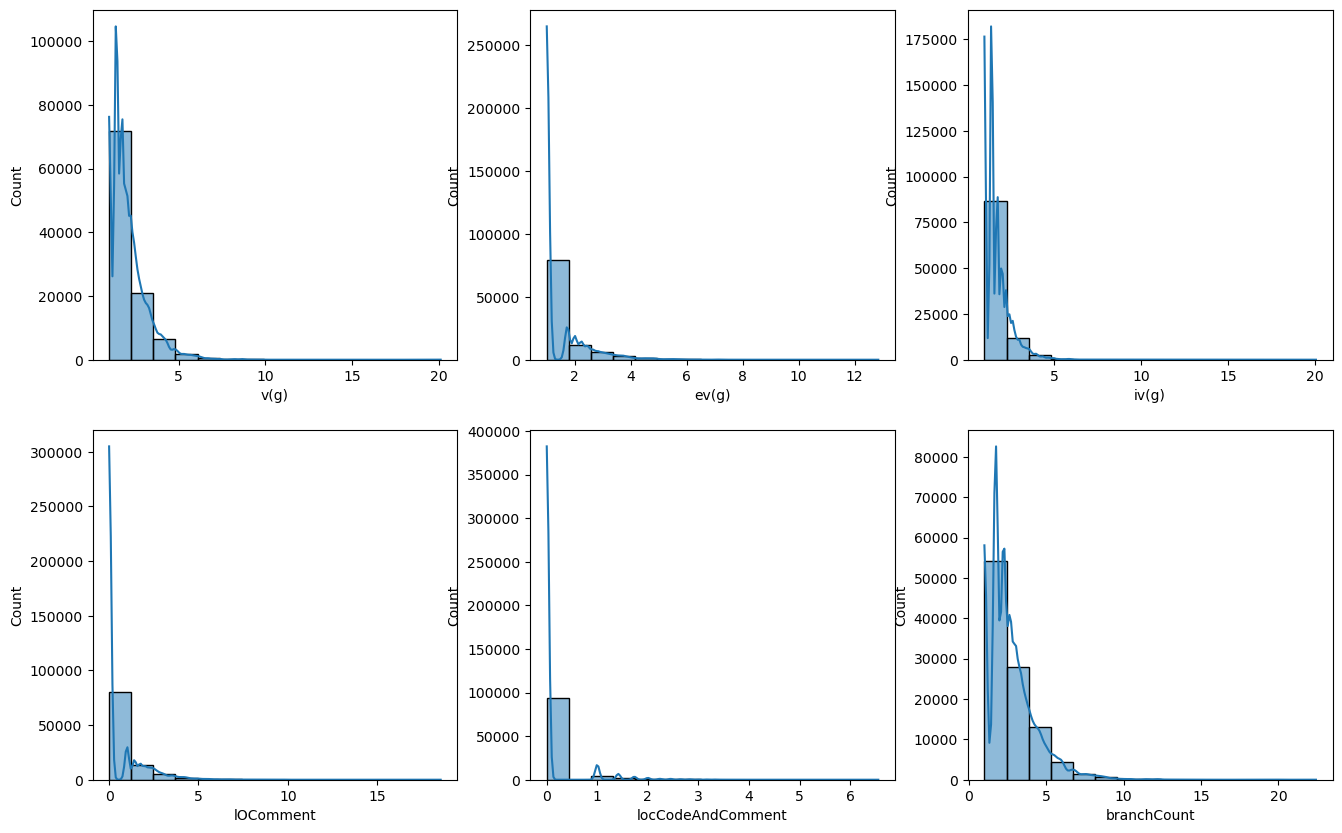

In [14]:
plot_dist_sqrt()
# Which is not as expected! So we will just kept all variable log-transformed

In [15]:
data.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


In [16]:
# Check NA values - None
data.isna().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [52]:
# One way to deal with imbalance - down / up sampling - SMOTE
# Paper: https://arxiv.org/pdf/1106.1813.pdf
X, y = data.drop(TAR, axis=1), data[TAR]
(counter := Counter(data[TAR].to_numpy().squeeze()))

Counter({False: 78699, True: 23064})

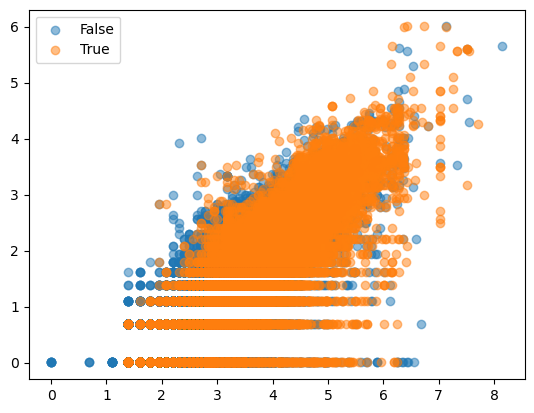

In [19]:
# Pre SMOTE
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(np.log(X.iloc[row_ix, 0] + .001), np.log(X.iloc[row_ix, 1] + .001), 
                label=str(label), alpha=0.5)
plt.legend()
plt.show()

In [53]:
def SMOTE_data(X, y):
    # Calculate Ratios
    counter = Counter(y.to_numpy().squeeze())
    total = dict(counter)[False] + dict(counter)[True]
    SMOTE_ratio = total // 2 / dict(counter)[False]
    RUS_ratio = 1

    # define pipeline
    over = SMOTE(sampling_strategy=SMOTE_ratio)
    under = RandomUnderSampler(sampling_strategy=RUS_ratio)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)

    return X, y

In [54]:
X, y = SMOTE_data(X, y)

In [55]:
y.value_counts()

defects
False      50881
True       50881
Name: count, dtype: int64

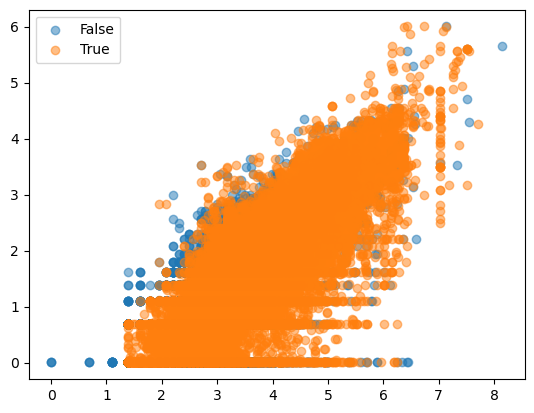

In [46]:
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(np.log(X.iloc[row_ix, 0] + .001), np.log(X.iloc[row_ix, 1] + .001),
                label=str(label), alpha=0.5)
plt.legend()
plt.show()